# Credit Card Fraud Detection — Baselines, PR/ROC, Threshold Tuning (+Optional SMOTE)

**What this notebook does**
- Loads the classic `creditcard.csv` dataset.
- Handles **severe class imbalance** with `class_weight="balanced"`.
- Trains **Logistic Regression** (with scaling) and **Random Forest** baselines.
- Evaluates with **ROC-AUC** and **Precision–Recall (PR-AUC)**, plus confusion matrices.
- **Tunes the decision threshold** using the PR curve to improve fraud recall/F1.
- *(Optional)* SMOTE oversampling cell you can enable if you want a stronger recall baseline.

**Outputs (saved to your working folder)**
- `metrics_summary.csv` — side-by-side metrics for each model & threshold setting.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

print("Working directory:", os.getcwd())

Working directory: /Users/jivalpatel/Downloads/Volunteer Work/Credit_Card_Fraud_Model


In [2]:
# --- Config & Load ---
CSV_PATH = "creditcard.csv"
if not os.path.exists(CSV_PATH):
    alt = "/mnt/data/creditcard.csv"
    if os.path.exists(alt):
        CSV_PATH = alt
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class counts:
 Class
0    284315
1       492
Name: count, dtype: int64

Class ratios:
 Class
0    0.998273
1    0.001727
Name: count, dtype: float64


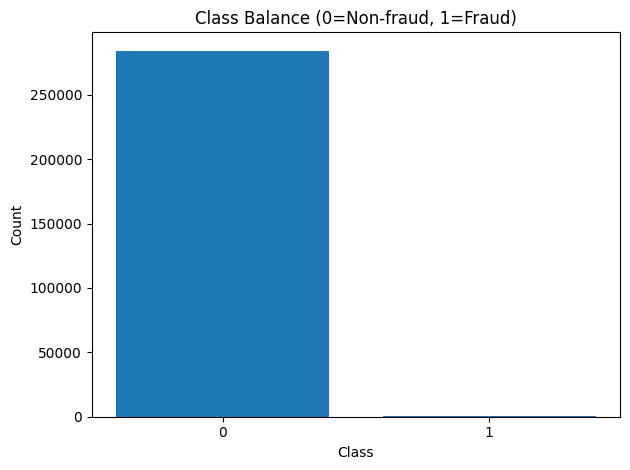

In [3]:
# Target and features
y = df["Class"]
X = df.drop(columns=["Class"])

# Class balance
class_counts = y.value_counts().sort_index()
class_ratio = (class_counts / len(y)).round(6)
print("Class counts:\n", class_counts)
print("\nClass ratios:\n", class_ratio)

plt.figure()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Class Balance (0=Non-fraud, 1=Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [4]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (227845, 30)  Test size: (56962, 30)


In [5]:
def metrics_from_scores(y_true, scores, threshold=0.5):
    preds = (scores >= threshold).astype(int)
    report = classification_report(y_true, preds, output_dict=True)
    roc = roc_auc_score(y_true, scores)
    prec, rec, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(rec, prec)
    cm = confusion_matrix(y_true, preds)
    return report, roc, pr_auc, cm

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Pred 0', 'Pred 1'])
    plt.yticks(tick_marks, ['Actual 0', 'Actual 1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.tight_layout()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def best_threshold_for_f1(y_true, scores):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    f1s = 2 * (prec * rec) / np.maximum(prec + rec, 1e-12)
    best_idx = np.nanargmax(f1s[:-1])  # align with thresholds length
    return float(thr[best_idx]), float(f1s[best_idx]), float(prec[best_idx]), float(rec[best_idx])

In [6]:
# Train baselines
lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"))
])
lr.fit(X_train, y_train)

rf = RandomForestClassifier(
    n_estimators=150, random_state=42, class_weight="balanced", n_jobs=-1
)
rf.fit(X_train, y_train)

# Scores
lr_scores = lr.predict_proba(X_test)[:, 1]
rf_scores = rf.predict_proba(X_test)[:, 1]

In [7]:
# Default threshold
lr_report, lr_roc, lr_pr_auc, lr_cm = metrics_from_scores(y_test, lr_scores, threshold=0.5)
rf_report, rf_roc, rf_pr_auc, rf_cm = metrics_from_scores(y_test, rf_scores, threshold=0.5)

summary_default = pd.DataFrame([
    {"Model": "LogReg (balanced) @0.5", "ROC_AUC": lr_roc, "PR_AUC": lr_pr_auc,
     "Precision_fraud": lr_report["1"]["precision"], "Recall_fraud": lr_report["1"]["recall"], "F1_fraud": lr_report["1"]["f1-score"]},
    {"Model": "RandomForest (balanced) @0.5", "ROC_AUC": rf_roc, "PR_AUC": rf_pr_auc,
     "Precision_fraud": rf_report["1"]["precision"], "Recall_fraud": rf_report["1"]["recall"], "F1_fraud": rf_report["1"]["f1-score"]},
]).round(4)

summary_default

,Model,ROC_AUC,PR_AUC,Precision_fraud,Recall_fraud,F1_fraud
0,LogReg (balanced) @0.5,0.9721,0.7656,0.0609,0.9184,0.1143
1,RandomForest (balanced) @0.5,0.9576,0.8606,0.9610,0.7551,0.8457


<Figure size 640x480 with 0 Axes>

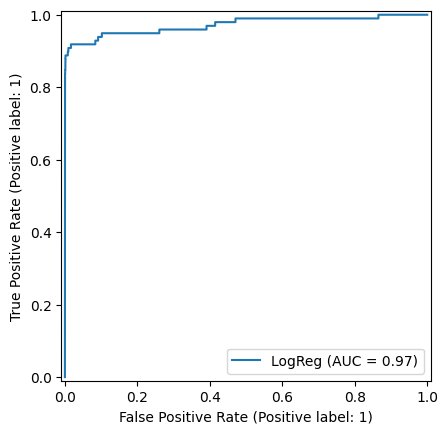

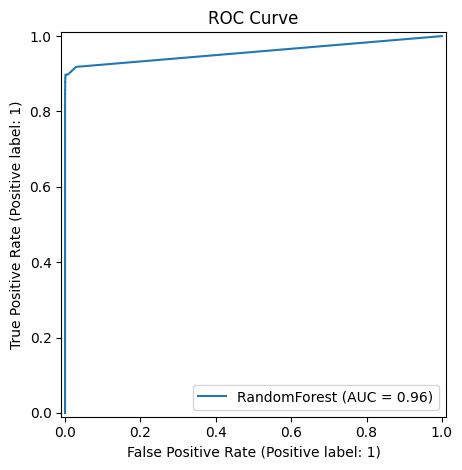

<Figure size 640x480 with 0 Axes>

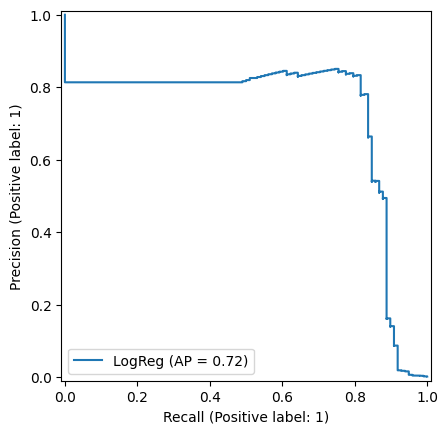

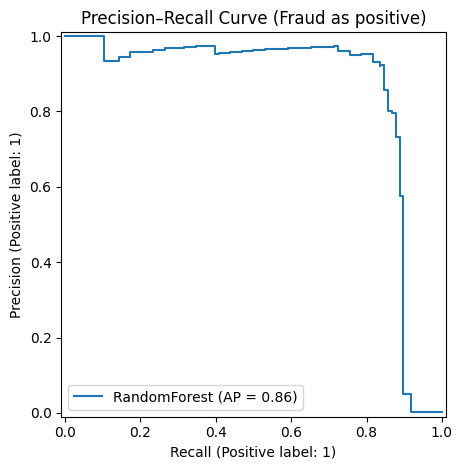

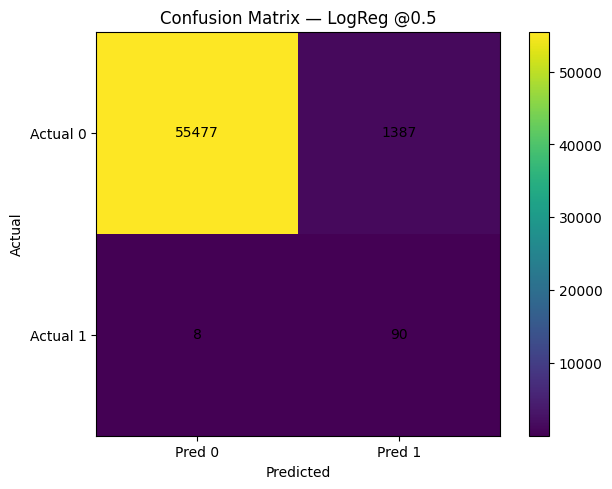

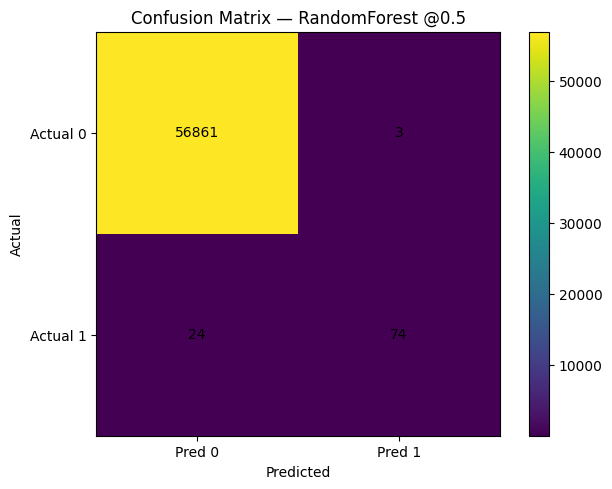

In [8]:
# Curves + confusion matrices
plt.figure()
RocCurveDisplay.from_predictions(y_test, lr_scores, name="LogReg")
RocCurveDisplay.from_predictions(y_test, rf_scores, name="RandomForest")
plt.title("ROC Curve")
plt.tight_layout()
plt.show()

plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, lr_scores, name="LogReg")
PrecisionRecallDisplay.from_predictions(y_test, rf_scores, name="RandomForest")
plt.title("Precision–Recall Curve (Fraud as positive)")
plt.tight_layout()
plt.show()

plot_confusion_matrix(lr_cm, title="Confusion Matrix — LogReg @0.5")
plot_confusion_matrix(rf_cm, title="Confusion Matrix — RandomForest @0.5")

LogReg best threshold for F1 (fraud): 1.0000 | F1=0.8247, P=0.8333, R=0.8163
RandomForest best threshold for F1 (fraud): 0.2867 | F1=0.8830, P=0.9222, R=0.8469


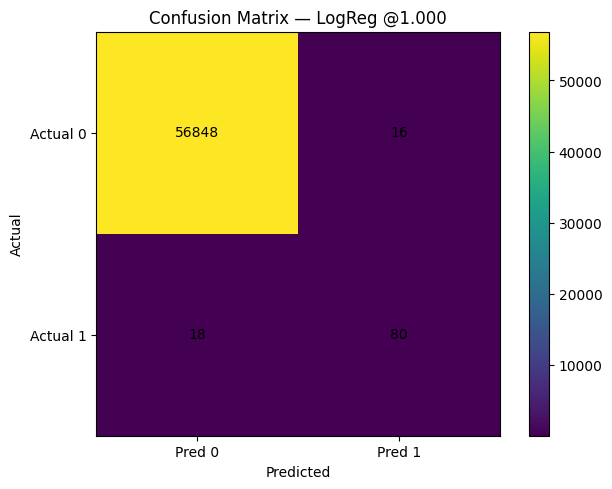

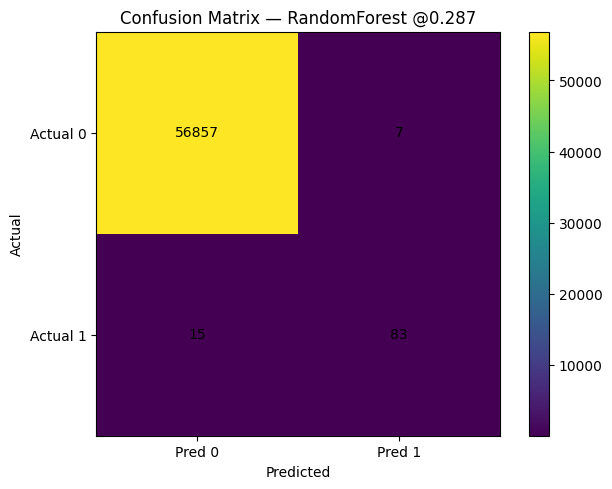

,Model,ROC_AUC,PR_AUC,Precision_fraud,Recall_fraud,F1_fraud
0,LogReg (balanced) @0.5,0.9721,0.7656,0.0609,0.9184,0.1143
1,RandomForest (balanced) @0.5,0.9576,0.8606,0.9610,0.7551,0.8457
2,LogReg (balanced) @1.000,0.9721,0.7656,0.8333,0.8163,0.8247
3,RandomForest (balanced) @0.287,0.9576,0.8606,0.9222,0.8469,0.8830


In [9]:
# Threshold tuning
lr_thr, lr_f1, lr_prec, lr_rec = best_threshold_for_f1(y_test, lr_scores)
rf_thr, rf_f1, rf_prec, rf_rec = best_threshold_for_f1(y_test, rf_scores)

print(f"LogReg best threshold for F1 (fraud): {lr_thr:.4f} | F1={lr_f1:.4f}, P={lr_prec:.4f}, R={lr_rec:.4f}")
print(f"RandomForest best threshold for F1 (fraud): {rf_thr:.4f} | F1={rf_f1:.4f}, P={rf_prec:.4f}, R={rf_rec:.4f}")

lr_rep_t, lr_roc_t, lr_pr_auc_t, lr_cm_t = metrics_from_scores(y_test, lr_scores, threshold=lr_thr)
rf_rep_t, rf_roc_t, rf_pr_auc_t, rf_cm_t = metrics_from_scores(y_test, rf_scores, threshold=rf_thr)

summary_tuned = pd.DataFrame([
    {"Model": f"LogReg (balanced) @{lr_thr:.3f}", "ROC_AUC": lr_roc_t, "PR_AUC": lr_pr_auc_t,
     "Precision_fraud": lr_rep_t["1"]["precision"], "Recall_fraud": lr_rep_t["1"]["recall"], "F1_fraud": lr_rep_t["1"]["f1-score"]},
    {"Model": f"RandomForest (balanced) @{rf_thr:.3f}", "ROC_AUC": rf_roc_t, "PR_AUC": rf_pr_auc_t,
     "Precision_fraud": rf_rep_t["1"]["precision"], "Recall_fraud": rf_rep_t["1"]["recall"], "F1_fraud": rf_rep_t["1"]["f1-score"]},
]).round(4)

plot_confusion_matrix(lr_cm_t, title=f"Confusion Matrix — LogReg @{lr_thr:.3f}")
plot_confusion_matrix(rf_cm_t, title=f"Confusion Matrix — RandomForest @{rf_thr:.3f}")

pd.concat([summary_default, summary_tuned], axis=0).reset_index(drop=True)

## Optional: Oversampling with SMOTE
To try SMOTE (can increase recall for the minority class):

```python
# Run once to install (in a notebook cell):
# !pip install imbalanced-learn
```
Then run the cell below.

In [10]:
try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except Exception:
    HAS_SMOTE = False
    print("SMOTE not available. Install with `pip install imbalanced-learn` to enable.")

if HAS_SMOTE:
    sm = SMOTE(random_state=42, sampling_strategy=1.0)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print("After SMOTE:", X_train_sm.shape, " Fraud rate:", y_train_sm.mean())

    lr_sm = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(max_iter=1000, class_weight=None, solver="lbfgs"))
    ])
    rf_sm = RandomForestClassifier(n_estimators=150, random_state=42, class_weight=None, n_jobs=-1)

    lr_sm.fit(X_train_sm, y_train_sm)
    rf_sm.fit(X_train_sm, y_train_sm)

    lr_sm_scores = lr_sm.predict_proba(X_test)[:, 1]
    rf_sm_scores = rf_sm.predict_proba(X_test)[:, 1]

    lr_sm_rep, lr_sm_roc, lr_sm_pr, lr_sm_cm = metrics_from_scores(y_test, lr_sm_scores, threshold=0.5)
    rf_sm_rep, rf_sm_roc, rf_sm_pr, rf_sm_cm = metrics_from_scores(y_test, rf_sm_scores, threshold=0.5)

    print("SMOTE — LogReg @0.5: ROC-AUC=", round(lr_sm_roc,4), " PR-AUC=", round(lr_sm_pr,4))
    print("SMOTE — RandomForest @0.5: ROC-AUC=", round(rf_sm_roc,4), " PR-AUC=", round(rf_sm_pr,4))

SMOTE not available. Install with `pip install imbalanced-learn` to enable.


In [12]:
# Save metrics
full_metrics = pd.concat([summary_default, summary_tuned], axis=0).reset_index(drop=True)
full_metrics.to_csv("metrics_summary.csv", index=False)
print("Saved metrics_summary.csv")
full_metrics

Saved metrics_summary.csv


,Model,ROC_AUC,PR_AUC,Precision_fraud,Recall_fraud,F1_fraud
0,LogReg (balanced) @0.5,0.9721,0.7656,0.0609,0.9184,0.1143
1,RandomForest (balanced) @0.5,0.9576,0.8606,0.9610,0.7551,0.8457
2,LogReg (balanced) @1.000,0.9721,0.7656,0.8333,0.8163,0.8247
3,RandomForest (balanced) @0.287,0.9576,0.8606,0.9222,0.8469,0.8830
